In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Add, Average, Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from imutils import paths
import skimage.measure
from google.colab.patches import cv2_imshow


In [ ]:
class DataGenerator(Sequence):
    def __init__(self, data_dir, mode='fit', batch_size=8,dim=(256, 256),scale=0.5, channels=3, shuffle=True):
        self.list_image = list(paths.list_images(data_dir))
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.scale=scale
        self.channels = channels
        self.shuffle = shuffle
        self.on_epoch_end()
   
    # phương thức này sẽ được tự đông gọi khi kết thúc 1 epoch, để đảo ngẫu nhiên lại thứ tự các ảnh khi train
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_image))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    # trả về số lượng batch
    def __len__(self):
        return int(np.floor(len(self.list_image) / self.batch_size))
    
    # trả về batch tương ứng với index
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        if self.mode == 'fit':
            # các train data của batch đó sẽ được lưu vào biến X
            X = np.empty((self.batch_size, *(self.dim), self.channels))
            # nếu model đang train thì cần tạo thêm dữ liệu về ảnh gốc của batch đó
            y = np.empty((self.batch_size, *self.dim, self.channels))
            for i, ID in enumerate(batch_indexes):
                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)

                # giảm độ phân giải hình ảnh bẳng cách dùng avg pooling theo đúng scale
                pooling_size = int(1/self.scale)
                img = skimage.measure.block_reduce(img, (pooling_size,pooling_size,1), np.mean)

                # xong lại upscale theo phương pháp bicubic interpolation
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                X[i] = img

                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                y[i] = img
            return X,y
                
                
        # nếu model đang predict thì không cần tạo thêm dữ liệu về ảnh gốc của batch đó
        elif self.mode == 'predict':
            X = np.empty((self.batch_size, *(self.dim), self.channels))
            for i, ID in enumerate(batch_indexes):
                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)

                # giảm độ phân giải hình ảnh bẳng cách dùng avg pooling theo đúng scale
                pooling_size = int(1/self.scale)
                img = skimage.measure.block_reduce(img, (pooling_size,pooling_size,1), np.mean)

                # xong lại upscale theo phương pháp bicubic interpolation
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                X[i] = img
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            

# 1. Super Resolution CNN

In [ ]:
def SRCNN(input_shape):
  X_input = Input(shape = input_shape)
  X = Conv2D(64, (9,9), activation = 'relu', padding = 'same')(X_input)
  X = BatchNormalization(axis = 3)(X)
  X = Conv2D(32, (1,1), activation = 'relu', padding = 'same')(X)
  X = BatchNormalization(axis = 3)(X)
  out = Conv2D(3,(5,5), activation = 'relu', padding = 'same')(X)
  model = Model(inputs = X_input, outputs = out, name = 'SRCNN')
  return model

In [ ]:
model = SRCNN((256,256,3))
model.summary()

Model: "SRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      15616     
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      2080      
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 3)       2403  

In [ ]:
model.compile(optimizer='adam', loss = 'mse')

In [ ]:
train_data_generator= DataGenerator('/content/drive/Shareddrives/PMAT/Datasets/HR/Train')
val_data_generator= DataGenerator('/content/drive/Shareddrives/PMAT/Datasets/HR/Valid')

In [ ]:
early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/weights/SRCNN.h5',save_best_only=True)

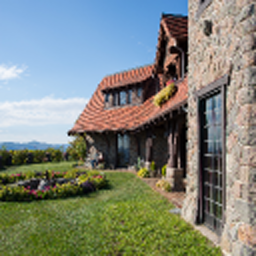

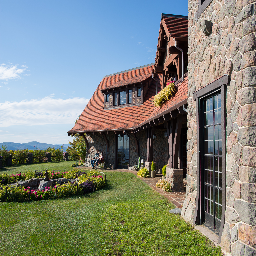

In [ ]:
#lấy thử cuối cùng của batch thứ 10 xem thử
img_lr= train_data_generator[10][0][-1]
img_hr=train_data_generator[10][1][-1]
cv2_imshow(img_lr)
cv2_imshow(img_hr)

In [ ]:
H= model.fit(train_data_generator,validation_data=val_data_generator,verbose = 1, epochs = 100, callbacks=[early, checkpoint])

Epoch 1/30
100/100 [==============================] - 268s 3s/step - loss: 11775.9375 - val_loss: 2283.6143
Epoch 2/30
100/100 [==============================] - 173s 2s/step - loss: 4344.0142 - val_loss: 2447.0178
Epoch 3/30
100/100 [==============================] - 174s 2s/step - loss: 2524.7520 - val_loss: 1788.7921
Epoch 4/30
100/100 [==============================] - 170s 2s/step - loss: 1584.2974 - val_loss: 5812.1973
Epoch 5/30
100/100 [==============================] - 172s 2s/step - loss: 1143.6418 - val_loss: 4551.5654
Epoch 6/30
100/100 [==============================] - 170s 2s/step - loss: 990.3218 - val_loss: 3373.4695
Epoch 7/30
100/100 [==============================] - 169s 2s/step - loss: 874.9130 - val_loss: 884.6248
Epoch 8/30
100/100 [==============================] - 168s 2s/step - loss: 863.8960 - val_loss: 1295.5553
Epoch 9/30
100/100 [==============================] - 169s 2s/step - loss: 789.0861 - val_loss: 1166.5006
Epoch 10/30
100/100 [====================

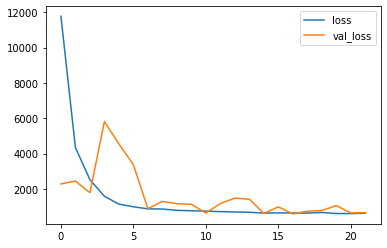

In [ ]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [ ]:
test_img=img_lr.reshape([1,*img_lr.shape])

In [ ]:
test_img.shape

(1, 256, 256, 3)

In [ ]:
output= model.predict(test_img)

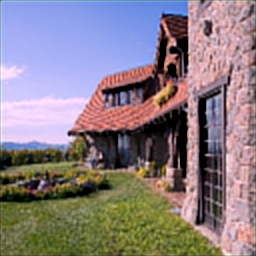

In [ ]:
cv2_imshow(output[0])

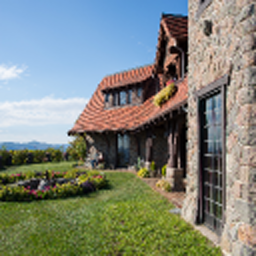

In [ ]:
cv2_imshow(img_lr)

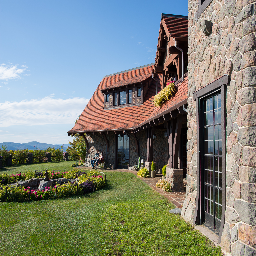

In [ ]:
cv2_imshow(img_hr)